<a href="https://colab.research.google.com/github/MarshaGomez/CNN-Medical-Imaging-Analysis/blob/main/Code/BaselineCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Project Setup


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True) 


Mounted at /content/gdrive


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools
import numpy as np
import pandas as pd 
import ast #Abstract Syntax Trees
import os 
import gc # Garbage Collector

from tensorflow.keras import backend as K # Useful to free GPU and memory
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from keras import layers, optimizers, models, regularizers, metrics
from keras.models import load_model
#ROC-AUC 
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from keras.wrappers.scikit_learn import KerasClassifier

#print confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import matplotlib.pyplot as plt

BATCH_SIZE = 20
EPOCHS = 100
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150

base_path = "/content/gdrive/My Drive/Colab_Notebooks/CIDL/DL Project"
PLOTS_PATH =  os.path.join(base_path, 'plots/Benign-Malign')
train_img_path = os.path.join(base_path, 'numpy data/train_tensor.npy')
train_label_path = os.path.join(base_path, 'numpy data/train_labels.npy')
test_img_path = os.path.join(base_path, 'numpy data/public_test_tensor.npy')
test_label_path = os.path.join(base_path, 'numpy data/public_test_labels.npy')

MODEL_PATH = os.path.join(base_path, "models/Baseline")

# to produce final model report histogram 
AUC_values_1x = []
AUC_values_3x = []
AUC_values_5x = []
TPR_values = []
FPR_values = []
ACC_values_1x = []
ACC_values_3x = []
ACC_values_5x = []

# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
      gc.collect()

print("Done")

Done


##1.1 Utility Functions

In [ ]:
# ----------------------- Utility Functions -----------------------
def load_training():
  train_images = np.load(train_img_path)
  train_labels = np.load(train_label_path)
  test_images = np.load(test_img_path)
  test_labels = np.load(test_label_path)

  return train_images, train_labels, test_images, test_labels

# Remove baseline samples
def remove_baseline(tensor): 
  max_ind = int(len(tensor)/2)
  indexes = [2*i + 1 for i in range(0, max_ind)]

  return tensor[indexes]

# Interchange the dataset index
def shuffle_dataset(x, y):
  indices = tf.range(start=0, limit=tf.shape(x)[0], dtype=tf.int32)
  shuffled_indices = tf.random.shuffle(indices)

  x = tf.gather(x, shuffled_indices)
  y = tf.gather(y, shuffled_indices)

  x = x.numpy()
  y = y.numpy()

  return x, y

# split dataset into training and validation set 70-30
def split_train_val(dataset, labels):
  train_data_split = dataset[:int(0.8*len(dataset))]
  valid_data_split = dataset[int(0.8*len(dataset)):]
  train_labels_split = labels[:int(0.8*len(labels))]
  valid_labels_split = labels[int(0.8*len(labels)):]

  print(train_data_split.shape)
  print(valid_data_split.shape)
  print(train_labels_split.shape)
  print(valid_labels_split.shape)      

  return train_data_split, valid_data_split, train_labels_split, valid_labels_split

# Unify masses and calcifications 
def labels_mapping(labels):
  labels_local = np.zeros(shape=(int(labels.shape[0]/2),), dtype="float32")
  idx = 0
  for label in labels:
    # Masses
    if label == 1 or label == 2:
      labels_local[idx] = 0
      idx += 1
    # Calcifications
    if label == 3 or label == 4:
      labels_local[idx] = 1
      idx += 1

  return labels_local

# Split baseline samples from abnormality samples 
def split_base_abnorm(train_images):
  train_baselines = np.zeros(shape=(2676, 150, 150), dtype="float32")
  train_abnormalities = np.zeros(shape=(2676, 150, 150), dtype="float32")

  #get even posititions
  train_baselines = train_images[::2]
  
  #get odd positions 
  train_abnormalities = train_images[1::2]

  return train_baselines, train_abnormalities

def get_model_predictions(model, dataset, labels, sample_count): 
  predictions = np.zeros((sample_count,))   

  BATCH_SIZE = 1
  i = 0
  for batch, labels_batch in test_datagen.flow(dataset, labels, batch_size=BATCH_SIZE, shuffle=False):
    predictions[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = model.predict(batch)
    i += 1

    if i * BATCH_SIZE  >= sample_count:
      break

    #np.where(predictions < 0.5, 0, 1)
    #predictions = np.where(predictions < 0.5, 0, 1)

  return predictions


def get_model_pred_prob(model, dataset, labels, sample_count): 
  predictions = np.zeros((sample_count,))   

  BATCH_SIZE = 1
  i = 0
  for batch, labels_batch in test_datagen.flow(dataset, labels, batch_size=BATCH_SIZE, shuffle=False):
    predictions[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = model.predict_classes(batch)
    i += 1

    if i * BATCH_SIZE  >= sample_count:
      break

  return predictions

# Function to calculate True Positive Rate and False Positive Rate
def calc_TP_FP_rate(y_true, y_pred):    
    # Instantiate counters
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    # Determine whether each prediction is TP, FP, TN, or FN
    for i in range(len(y_true)): 
        if y_true[i]==y_pred[i]==1.:
           TP += 1
        if y_pred[i]==1. and y_true[i]!=y_pred[i]:
           FP += 1
        if y_true[i]==y_pred[i]==0.:
           TN += 1
        if y_pred[i]==0. and y_true[i]!=y_pred[i]:
           FN += 1
    
    print("TP: ", TP)
    print("FP: ", FP)
    print("TN: ", TN)
    print("FN: ", FN)
    
    #Precision = TP/(TP+FP)
      #Precision answers the following: How many of those who we labeled as diabetic are actually diabetic?
    precision = TP / (TP + FP)

    #Recall/Sensitivity/TPR = TP/(TP+FN)
        #Recall answers the following question: Of all the people who are diabetic, how many of those we correctly predict?
    tpr = TP / (TP + FN)

    #Specificity = TN/(TN+FP)
        #Specifity answers the following question: Of all the people who are healthy, how many of those did we correctly predict?
    specificity = TN / (TN + FP)

    #FPR  = 1 - Specificity =  FP/FP+TN
    fpr = FP / (FP + TN)

    return tpr, fpr, precision, specificity

print("Done")

Done


##1.2 Visualization Functions

In [ ]:
# Visualization Data Histogram
def plot_acc(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.figure()
  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  return plt

def plot_loss(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  return plt


def plot_confusion_matrix(model,
                          classes,
                          dataset, 
                          labels,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    Y_pred = model.predict(test_datagen.flow(dataset,
                                            labels,
                                            batch_size=21,
                                            shuffle=False),
                          steps=len(dataset) // BATCH_SIZE)

    np.where(Y_pred < 0.5, 0, 1)
    y_pred = np.where(Y_pred < 0.5, 0, 1)

    print('Confusion Matrix')
    cm = confusion_matrix(labels, y_pred)

    #print(cm)
    #print('Classification Report')
    print(classification_report(labels, y_pred))


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return plt

# Visualization Detail Metric
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)

    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
    if metrics[-1] != metric:
      plt.figure()

  return plt, cm

def plot_AUC(model, dataset, labels):
  y_pred_keras = get_model_predictions(model, dataset, labels, len(dataset))
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(labels, y_pred_keras)
  #thresholds_keras = np.linspace(0,1,num=100)
  auc_keras = auc(fpr_keras, tpr_keras)

  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_keras, tpr_keras, label='CNN (area = {:.3f})'.format(auc_keras))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  #plt.show()

  return auc_keras, plt
print("Done")

Done


#2 Data Preparation


In [ ]:
# Get images and labels (test, train)
train_images, train_labels, test_images, test_labels = load_training()

print("Train shape: ", train_images.shape)
print("Train labels shape: ", train_labels.shape)
print()
print("Test shape: ", test_images.shape)
print("Test labels shape: ", test_labels.shape)

Train shape:  (5352, 150, 150)
Train labels shape:  (5352,)

Test shape:  (672, 150, 150)
Test labels shape:  (672,)


In [ ]:
train_baselines, train_abnormalities = split_base_abnorm(train_images)
test_baselines, test_abnormalities = split_base_abnorm(test_images)

print("Train baselines shape: ", train_baselines.shape)
print("Train abnormalities shape: ", train_abnormalities.shape)
print("Test baselines shape: ", test_baselines.shape)
print("Test abnormalities shape: ", test_abnormalities.shape)

Train baselines shape:  (2676, 150, 150)
Train abnormalities shape:  (2676, 150, 150)
Test baselines shape:  (336, 150, 150)
Test abnormalities shape:  (336, 150, 150)


In [ ]:
#stack abnormality on top of the relative baseline
baseline = train_images[0]
abnormality = train_images[1]

print(train_baselines.shape)
print(train_abnormalities.shape)

#train_images = np.stack([train_abnormalities, train_baselines, train_abnormalities], axis=3)
train_images = np.stack([train_abnormalities, train_baselines, train_baselines], axis=3)
print("Staked shape:", train_images_stacked.shape)

(2676, 150, 150)
(2676, 150, 150)
Staked shape: (2676, 150, 150, 3)


In [ ]:
train_labels = labels_mapping(train_labels)
test_labels = labels_mapping(test_labels)

print("Train labels shape: ", train_labels.shape)
print("Test labels shape: ", test_labels.shape)

Train labels shape:  (2676,)
Test labels shape:  (336,)


In [ ]:
# Suffle index (Previous dataset is ordered)
train_images, train_labels = shuffle_dataset(train_images, train_labels)

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split = split_train_val(train_images, train_labels)  

(2140, 150, 150, 3)
(536, 150, 150, 3)
(2140,)
(536,)


In [ ]:
test_images = test_abnormalities.reshape(test_abnormalities.shape + (1,)) #(2676, 150, 150, 1)
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print("Train shape: ", train_images.shape)
print("Test shape: ", test_images.shape)

Train shape:  (2676, 150, 150, 3)
Test shape:  (336, 150, 150, 3)


In [ ]:
from tensorflow.keras.applications.resnet import preprocess_input
train_datagen = ImageDataGenerator(rescale=1./65535, preprocessing_function=preprocess_input)
valid_datagen = ImageDataGenerator(rescale=1./65535, preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(rescale=1./65535, preprocessing_function=preprocess_input) 

##2.1 Data Visualization

In [ ]:
from PIL import Image
from matplotlib.pyplot import figure, imshow, axis

train_images = train_images.reshape(train_images.shape + (1,)) #(2676, 150, 150, 1)
test_images = test_images.reshape(test_images.shape + (1,)) #(2676, 150, 150, 1)

def display_samples(idx):
  assert idx % 2 == 0
  counter = 0
  fig = figure(figsize=(8,4))
  while counter < 2:
    img = test_images[idx]
    pil_img = tf.keras.preprocessing.image.array_to_img(img)
    a=fig.add_subplot(1, 2, counter+1)
    imshow(pil_img,cmap='Greys_r')

    counter += 1
    idx += 1

print("\tBaseline patch           VS\t Abnormality patch")
display_samples(0)
display_samples(2)
display_samples(4)
display_samples(6)

##2.5 All-in-one Data Preparation Function

# 5.Inception V3: Flatten() + 5x [Dropout(0.5), Dense(256)]

## 3.4.2 3-Fine-Tuning Strategy With Data Augmentation

In [ ]:
from keras.applications import InceptionV3

conv_base = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(150, 150, 3))
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_InceptionV3_3FT_DA_5x')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=100,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

#unfreeze last 3 convolutional blocks
conv_base.trainable = True
set_trainable = False 
for layer in conv_base.layers:
  if layer.name == "block3_conv1":
    set_trainable = True
  if set_trainable:
    layer.trainable = True 
  else: 
    layer.trainable = False 

model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-5), # lr = 0.00001
            metrics=METRICS)   

#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_4 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 18432)             0         
_________________________________________________________________
dense_24 (Dense)             (None, 256)               4718848   
_________________________________________________________________
dropout_21 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_22 (Dropout)         (None, 256)              

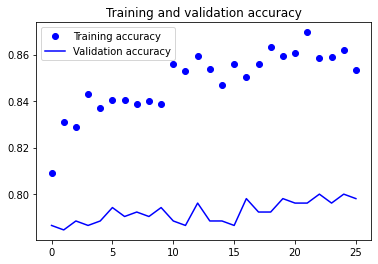

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

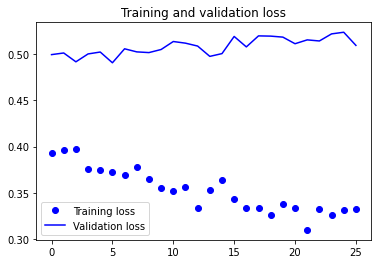

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")
ACC_values_5x.append(test_accuracy)

16/16 [==============================] - 1s 30ms/step - loss: 1.0230 - acc: 0.5688

---------------------------------
Accuracy: 56.88 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.90      0.25      0.39       179
         1.0       0.53      0.97      0.68       157

    accuracy                           0.58       336
   macro avg       0.71      0.61      0.54       336
weighted avg       0.73      0.58      0.53       336



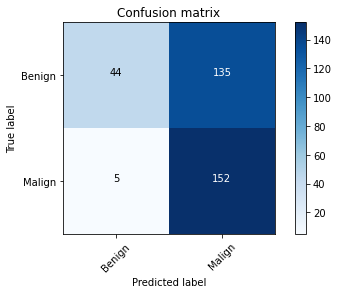

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

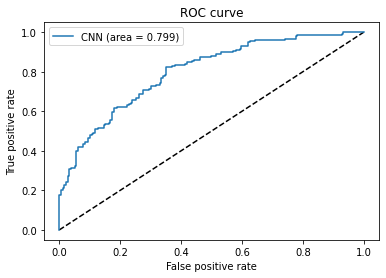

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values_5x.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
#free RAM 
del model
del conv_base
del train_images_split 
del valid_images_split 
del train_labels_split 
del valid_labels_split